In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import xgboost as xgb
import lightgbm as lgb
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning
import warnings

import streamlit as st

warnings.filterwarnings('ignore')
df = pd.read_csv('merged_dataset2.csv')

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df

,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,MTRANS,Class,Weight,CALC,NObeyesdad,BMI,class
0,1,14,171,1,1,3,3,2,2,3,2,2,2,5,NaN,72.000000,0,Normal_Weight,24.622961,Normal
1,1,16,167,1,1,2,1,3,2,3,2,1,1,4,NaN,50.000000,0,Insufficient_Weight,17.928215,Underweight
2,1,16,169,2,1,2,1,2,2,2,2,0,0,4,NaN,50.000000,1,Insufficient_Weight,17.481431,Underweight
3,1,16,169,2,1,2,2,2,2,2,2,0,0,4,NaN,52.629374,1,Insufficient_Weight,18.405067,Underweight
4,1,16,175,2,1,2,3,2,2,1,2,1,1,4,NaN,50.000000,1,Insufficient_Weight,16.275246,Underweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,2,54,169,2,2,2,1,2,2,2,1,2,0,1,Overweight,78.399945,NaN,NaN,NaN,NaN
3717,2,54,170,1,1,1,3,4,1,3,2,2,0,1,Obesity,93.925000,NaN,NaN,NaN,NaN
3718,2,54,174,2,1,1,3,3,2,2,1,2,0,1,Overweight,83.107620,NaN,NaN,NaN,NaN
3719,2,54,175,2,1,1,3,3,2,3,1,2,0,1,Overweight,84.065625,NaN,NaN,NaN,NaN


In [3]:
X = df[['Weight', 'Height', 'family_history_with_overweight', 'FAF', 'FCVC', 'TUE']]
y = df['BMI']  

# Remove rows with NaN values
X = X[~y.isna()]
y = y.dropna()

# Data Split
# Split the data into training and test sets using train_test_split, and standardize the data using StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Scarling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu',           
    solver='adam',                
    alpha=0.0001,                 
    learning_rate_init=0.001,   
    max_iter=200             
)

mlp_model

MLPRegressor(hidden_layer_sizes=(100, 50))

In [4]:
# 5-fold validation
cross_val_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)
cross_val_scores
# array avaerage = final accuracy

array([0.99729702, 0.99838268, 0.99896414, 0.99803326, 0.9985813 ])

In [5]:
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse)
print(r2)

0.04868696932815928
0.9992814399678434


In [6]:
# Hyperparameter optimization with HyperOpt

np.random.seed(2024)

estimate_space = {
   'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(100,), (100, 50), (200, 100), (200, 150, 100, 50)]),
   'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-2)),
   'learning_rate_init': hp.loguniform('learning_rate_init', np.log(1e-4), np.log(1e-2)),
   'max_iter': hp.quniform('max_iter', 200, 2000, 100)  
}


def objective(params):
   # random seed
   np.random.seed(2024)
   
   mlp_model = MLPRegressor(
       hidden_layer_sizes=params['hidden_layer_sizes'],
       activation='relu',
       solver='adam',
       alpha=params['alpha'],
       learning_rate_init=params['learning_rate_init'],
       max_iter=500,
       random_state=2024,
       shuffle=False  
   )
   
   score = cross_val_score(mlp_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
   return {'loss': -score, 'status': STATUS_OK}


trials = Trials()

best_parameter = fmin(
    fn=objective,
    space=estimate_space,
    algo=tpe.suggest,
    max_evals=50,  
    trials=trials,
    rstate=np.random.default_rng(2024)
)


# Best Hyperparameters result : {'alpha': 0.00046443440409051144, 'hidden_layer_sizes': 3, 'learning_rate_init': 0.009829290091274815, 'max_iter': 900.0}

# {'alpha': 0.0014053639037901015, 'hidden_layer_sizes': (200, 150, 100, 50), 'learning_rate_init': 0.006537959433035273, 'max_iter': 1900.0}


100%|███████| 50/50 [03:04<00:00,  3.70s/trial, best loss: 0.028202565308011573]


In [7]:
print(best_parameter)
# {'alpha': 0.0014053639037901015, 'hidden_layer_sizes': (200, 150, 100, 50), 'learning_rate_init': 0.006537959433035273, 'max_iter': 1900.0}

{'alpha': np.float64(0.0014053639037901015), 'hidden_layer_sizes': np.int64(3), 'learning_rate_init': np.float64(0.006537959433035273), 'max_iter': np.float64(1900.0)}


In [8]:
hidden_layer_options = [(100,), (100, 50), (200, 100), (200, 150, 100, 50)]

best_parameter['hidden_layer_sizes'] = hidden_layer_options[best_parameter['hidden_layer_sizes']]

mlp_model = MLPRegressor(
    hidden_layer_sizes=best_parameter['hidden_layer_sizes'],
    activation='relu',
    solver='adam',
    alpha=best_parameter['alpha'],
    learning_rate_init=best_parameter['learning_rate_init'],
    max_iter=int(best_parameter.get('max_iter', 1600)) 
)

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE -> ", mse)
print("R2 Score -> ", r2)

#2nd try
# MSE ->  0.03392058736342574
# R2 Score ->  0.9994993736787691

MSE ->  0.03392058736342687
R2 Score ->  0.9994993736787691


In [9]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Adjusted R^2
def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

y_pred = mlp_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = adjusted_r2_score(r2, len(y_test), X_test.shape[1])

print("MSE ->", mse)
print("MAE ->", mae)
print("MAPE ->", mape)
print("R^2 Score ->", r2)
print("Adjusted R^2 Score ->", adjusted_r2)

#1st try
# MSE -> 0.02326885745219756
# MAE -> 0.12025047930605268
# MAPE -> 0.42407091825945614
# R^2 Score -> 0.9996565801652922
# Adjusted R^2 Score -> 0.9996516269945993
# -> Indicators improved compared to before
# Since the MSE and R² scores are very high, it is necessary to check for overfitting

#2nd try
# MSE -> 0.03392058736342574
# MAE -> 0.14004505564158393
# MAPE -> 0.4980128056694918
# R^2 Score -> 0.9994993736787691
# Adjusted R^2 Score -> 0.9994921531068283

MSE -> 0.03392058736342687
MAE -> 0.14004505564158634
MAPE -> 0.4980128056694999
R^2 Score -> 0.9994993736787691
Adjusted R^2 Score -> 0.9994921531068283


In [10]:
# for train data
y_train_pred = mlp_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# for test data
y_test_pred = mlp_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

# If the test MSE is more than 50% larger than the training MSE, consider the possibility of overfitting
if test_mse > train_mse * 1.5:  
    print("overfitting")
else:
    print("no significant signs of overfitting")
    
    
#2nd try
# Train MSE: 0.02633088503157679
# Test MSE: 0.03392058736342574
# Train MAE: 0.1268501941880027
# Test MAE: 0.14004505564158393

Train MSE: 0.02633088503157798
Test MSE: 0.03392058736342687
Train MAE: 0.1268501941880055
Test MAE: 0.14004505564158634
no significant signs of overfitting


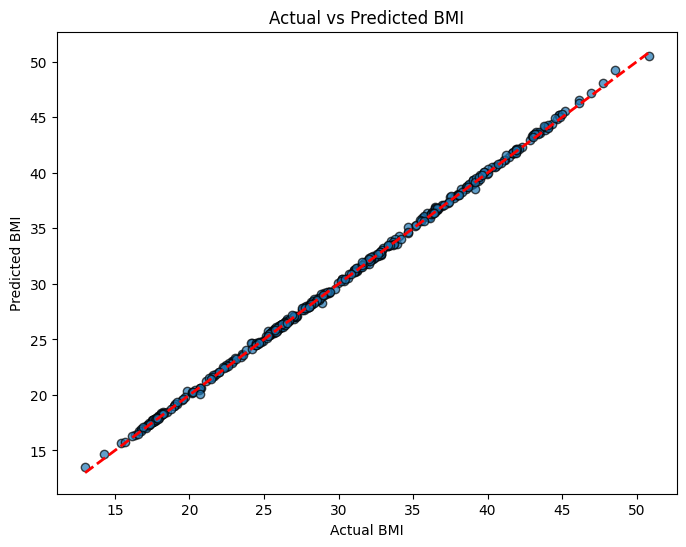

In [11]:
# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Actual vs Predicted BMI')
plt.show()

In [12]:
# 5-fold validation
cross_val_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)
cross_val_scores

array([0.99920126, 0.99948577, 0.99973059, 0.99943264, 0.99942858])